In [1]:
from graph_tool import Graph, Vertex
from graph_tool.draw import graph_draw
from graph_tool.util import find_vertex
from smodels.theory import crossSection
from smodels.tools.physicsUnits import pb, GeV, fb
import numpy as np
from scipy import stats
from collections import Iterable
import copy
from smodels.theory.exceptions import SModelSTheoryError as SModelSError
from smodels.tools.smodelsLogging import logger
from smodels.experiment.finalStateParticles import finalStates
from smodels.theory.particle import Particle
from smodels.theory.auxiliaryFunctions import elementsInStr


#Get all finalStateLabels
finalStateLabels = finalStates.getValuesFor('label')


In [2]:
def listToVertices(g,vList,momVertex):
    
    vMom = momVertex
    for v in vList:
        iv = g.add_vertex()
        if isinstance(v,list):
            g.vp.particle[iv] = finalStates.getParticlesWith(label='anyOdd')[0]
            g.add_edge(vMom,iv)
            listToVertices(g,v,vMom)
            vMom = iv            
        elif isinstance(v,str):
            g.vp.particle[iv] = finalStates.getParticlesWith(label=v)[0]
            g.add_edge(vMom,iv)
            

In [3]:
def stringToGraph(info,finalState=None):

    g = Graph(directed=True)
    g.vertex_properties['particle'] = g.new_vertex_property("object")
    g.vertex_properties['label'] = g.new_vertex_property("string")
    g.vertex_properties['inclusive'] = g.new_vertex_property("bool",False)
    v0 = g.add_vertex()
    g.vp.particle[v0] = Particle(label='PV')

    elements = elementsInStr(info,removeQuotes=False)
    if not elements or len(elements) > 1:
        nel = 0
        if elements:
            nel = len(elements)
        logger.error("Malformed input string. Number of elements "
                      "is %d (expected 1) in: ``%s''", nel, info)
        return None
    else:
        branches = eval(elements[0])
        if not branches or len(branches) != 2:
            logger.error("Malformed input string. Number of "
                          "branches is %d (expected 2) in: ``%s''",
                          len(branches), info)
            return None

        if finalState:
            if len(finalState) != len(branches):
                raise SModelSError("Number of final states (%i) does not match number of branches (%i)" 
                                   %(len(finalState),len(branches)))
        else:
            finalState = [None]*len(branches)                  
        for branch in branches:            
            iv = g.add_vertex()
            if branch == '[*]':
                g.vp.inclusive[iv] = True                
            else:            
                g.vp.particle[iv] = finalStates.getParticlesWith(label='anyOdd')[0]
                g.add_edge(v0,iv)    
                listToVertices(g,branch,iv)
            
    
    for iv,v in enumerate(g.vertices()):
        if v.out_degree():
            continue
        if g.vp.particle[iv].Z2parity != 'odd':
            continue        
        fs = finalState.pop(0)
        if fs is None:
            fs = 'MET'
        g.vp.particle[iv] = finalStates.getParticlesWith(label=fs)[0]
    
    for iv in g.get_vertices():
        g.vp.label[iv] = g.vp.particle[iv].label
    
    return g


In [4]:
elementStr = "[[['e+','e-']],[['mu-'],['jet','jet'],['L']]]"
g = stringToGraph(elementStr)

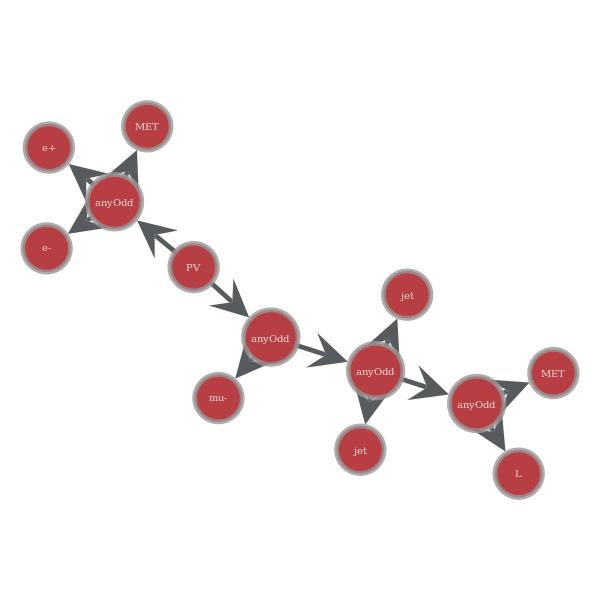

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f78fcffd5f8, at 0x7f79606d1d30>

In [5]:
graph_draw(g, vertex_text=g.vp.label, vertex_font_size=10, inline=True)

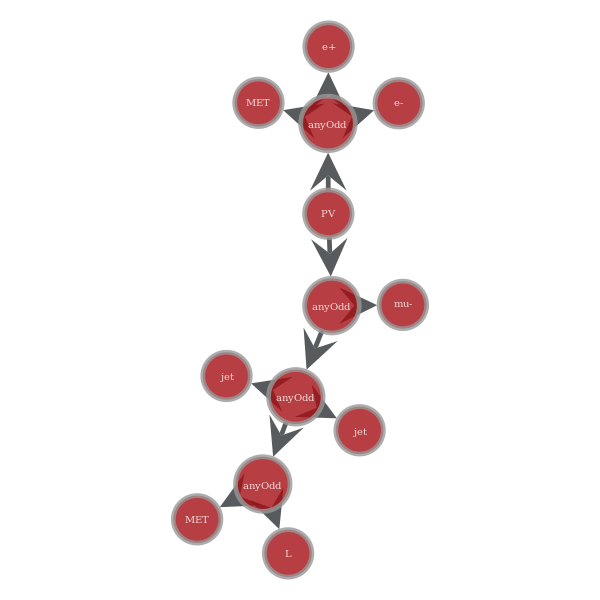

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f76140e2438, at 0x7f766442e438>

In [6]:
gB = Graph(g=g)
graph_draw(gB, vertex_text=gB.vp.label, vertex_font_size=10, inline=True)

In [6]:
from graph_tool.topology import isomorphism, subgraph_isomorphism

In [8]:
gB = Graph(g=g)

In [13]:
maps = subgraph_isomorphism(g,gB)

In [15]:
print(len(maps))

24


In [16]:
m = maps[0]
print(m)

<PropertyMap object with key type 'Vertex' and value type 'int64_t', for Graph 0x7f78fcffd5f8, at 0x7f79100f56a0>


In [18]:
for m in maps:
    mm = [m[v] for v in g.vertices()]
    ptc = [gB.vp.particle[m[v]] for v in g.vertices()]
    print(ptc)

[PV, anyOdd, MET, e+, e-, anyOdd, anyOdd, mu-, anyOdd, jet, jet, MET, L]
[PV, anyOdd, MET, e+, e-, anyOdd, anyOdd, mu-, anyOdd, jet, jet, L, MET]
[PV, anyOdd, MET, e+, e-, anyOdd, anyOdd, mu-, anyOdd, jet, jet, MET, L]
[PV, anyOdd, MET, e+, e-, anyOdd, anyOdd, mu-, anyOdd, jet, jet, L, MET]
[PV, anyOdd, MET, e-, e+, anyOdd, anyOdd, mu-, anyOdd, jet, jet, MET, L]
[PV, anyOdd, MET, e-, e+, anyOdd, anyOdd, mu-, anyOdd, jet, jet, L, MET]
[PV, anyOdd, MET, e-, e+, anyOdd, anyOdd, mu-, anyOdd, jet, jet, MET, L]
[PV, anyOdd, MET, e-, e+, anyOdd, anyOdd, mu-, anyOdd, jet, jet, L, MET]
[PV, anyOdd, e+, MET, e-, anyOdd, anyOdd, mu-, anyOdd, jet, jet, MET, L]
[PV, anyOdd, e+, MET, e-, anyOdd, anyOdd, mu-, anyOdd, jet, jet, L, MET]
[PV, anyOdd, e+, MET, e-, anyOdd, anyOdd, mu-, anyOdd, jet, jet, MET, L]
[PV, anyOdd, e+, MET, e-, anyOdd, anyOdd, mu-, anyOdd, jet, jet, L, MET]
[PV, anyOdd, e+, e-, MET, anyOdd, anyOdd, mu-, anyOdd, jet, jet, MET, L]
[PV, anyOdd, e+, e-, MET, anyOdd, anyOdd, mu-, anyO

In [21]:
sorted(g.degree_property_map('out').get_array())

list

In [23]:
[0,0,1] > [0,0,2]

False

In [27]:
print(max([g.vp.particle[v] for v in g.vertices()]))

PV
